<a href="https://colab.research.google.com/github/Quocat/portfolio/blob/main/WalmartForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# (Part 1) The following code is for reading, cleaning, and merging data

#### ** not all parts need to be run - skip to Part 2

In [ ]:
# read in data

calendar = pd.read_csv('calendar.csv')
sales_test_validation = pd.read_csv('sales_test_validation.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')
weights_validation = pd.read_csv('weights_validation.csv')

In [ ]:
# separate column names into lists to help rearrange data

id_list = ['item_id','dept_id', 'cat_id', 'store_id', 'state_id',]
days_list = sales_train_validation.columns.tolist()
for i in id_list: days_list.remove(i)
id_list.remove('item_id')
id_list.remove('dept_id')

In [ ]:
# create aggregation dictionary as key for aggregating - ids in id_list stay constant (max) and values in days are summed
aggregation_dict = {col: 'max' for col in id_list}
aggregation_dict.update({col: 'sum' for col in days_list})

# aggregate by cat_id and store_id
result = sales_train_validation.groupby(['cat_id', "store_id"]).agg(aggregation_dict)
result

cat_id store_id state_id   d_1   d_2   d_3   d_4   d_5  \
cat_id    store_id                                                              
FOODS     CA_1          FOODS     CA_1       CA  3239  3137  2008  2258  2032   
          CA_2          FOODS     CA_2       CA  2193  1921  1289  1540  1278   
          CA_3          FOODS     CA_3       CA  3446  3535  2701  3064  2761   
          CA_4          FOODS     CA_4       CA  1223  1269   946  1002  1107   
          TX_1          FOODS     TX_1       TX  1781  1903  1377  1643  1329   
          TX_2          FOODS     TX_2       TX  2788  2870  2082  2180  1890   
          TX_3          FOODS     TX_3       TX  2284  2257  1665  1647  1383   
          WI_1          FOODS     WI_1       WI  1581  1327   977   935     2   
          WI_2          FOODS     WI_2       WI  1615  1433  1586  2013   967   
          WI_3          FOODS     WI_3       WI  3028  3106  2543  2596  1854   
HOBBIES   CA_1        HOBBIES     CA_1       CA   556   498   415   392   268   
          CA_2        HOBBIES     CA_2       CA   538   397   368   350   296   
          CA_3        HOBBIES     CA_3       CA   550   430   438   424   364   
          CA_4        HOBBIES     CA_4       CA   158   236   251   239   253   
          TX_1        HOBBIES     TX_1       TX   251   264   107   248   102   
          TX_2        HOBBIES     TX_2       TX   385   359   229   359   257   
          TX_3        HOBBIES     TX_3       TX   243   247   190   202   142   
          WI_1        HOBBIES     WI_1       WI   615   443   323   137     0   
          WI_2        HOBBIES     WI_2       WI   190   127   113   124    58   
          WI_3        HOBBIES     WI_3       WI   278   356   248   194    74   
HOUSEHOLD CA_1      HOUSEHOLD     CA_1       CA   542   520   393   401   330   
          CA_2      HOUSEHOLD     CA_2       CA   763   728   464   434   368   
          CA_3      HOUSEHOLD     CA_3       CA   743   862   646   744   692   
          CA_4      HOUSEHOLD     CA_4       CA   244   272   189   199   176   
          TX_1      HOUSEHOLD     TX_1       TX   524   520   338   367   263   
          TX_2      HOUSEHOLD     TX_2       TX   679   708   420   415   345   
          TX_3      HOUSEHOLD     TX_3       TX   503   502   370   320   201   
          WI_1      HOUSEHOLD     WI_1       WI   508   424   262   179     0   
          WI_2      HOUSEHOLD     WI_2       WI   451   362   319   385   150   
          WI_3      HOUSEHOLD     WI_3       WI   732   736   526   421   204   

                     d_6   d_7  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
cat_id    store_id              ...                                           
FOODS     CA_1      2407  2693  ...    2706    3481    4004    2886    2488   
          CA_2      1494  1785  ...    2891    3423    3729    2625    2410   
          CA_3      3340  3455  ...    3471    4307    5127    3827    3468   
          CA_4      1015  1072  ...    1664    1883    1995    1879    1722   
          TX_1      2091  1247  ...    2049    2412    2629    2434    2113   
          TX_2      2696  1963  ...    2549    2795    3221    2268    2440   
          TX_3      2280  1461  ...    2396    2737    2867    2132    2513   
          WI_1      1278  1671  ...    2700    3195    3501    2282    2135   
          WI_2      1709  1668  ...    4836    4175    4157    3206    3282   
          WI_3      3783  3475  ...    3420    3599    3267    2612    2377   
HOBBIES   CA_1       467   346  ...     401     722     655     542     495   
          CA_2       391   316  ...     483     486     483     320     368   
          CA_3       390   493  ...     432     635     848     467     588   
          CA_4       211   159  ...     342     333     344     377     398   
          TX_1       292    89  ...     258     273     447     216     292   
          TX_2       318   162  ...     360     407     468     328     299   
        

In [ ]:
# switch day columns to rows

result_df = pd.DataFrame()
for i, day_i in enumerate(days_list):
    temp = result[id_list + [day_i]].reset_index(drop=True)
    temp = temp.rename(columns={day_i : 'sales'})
    temp = temp.assign(day=i+1)

    result_df = pd.concat([result_df, temp], ignore_index=True)

result_df

cat_id store_id state_id  sales   day
0          FOODS     CA_1       CA   3239     1
1          FOODS     CA_2       CA   2193     1
2          FOODS     CA_3       CA   3446     1
3          FOODS     CA_4       CA   1223     1
4          FOODS     TX_1       TX   1781     1
...          ...      ...      ...    ...   ...
57385  HOUSEHOLD     TX_2       TX   1026  1913
57386  HOUSEHOLD     TX_3       TX   1055  1913
57387  HOUSEHOLD     WI_1       WI    983  1913
57388  HOUSEHOLD     WI_2       WI   1233  1913
57389  HOUSEHOLD     WI_3       WI    967  1913

[57390 rows x 5 columns]

In [ ]:
# create dictionary of days to dates and merge main df with calendar

start_date = datetime.strptime('2011-01-29', '%Y-%m-%d')
num_days = 1913
days_dates_dict = {day: (start_date + timedelta(days=day - 1)).strftime('%Y-%m-%d') for day in range(1, num_days + 1)}
calendar['date'] = pd.to_datetime(calendar['date'])
date_format = '%Y-%m-%d'
calendar['date'] = calendar['date'].dt.strftime(date_format)
result_df['date'] = result_df['day'].map(days_dates_dict)
result_df = pd.merge(result_df, calendar, on='date', how='left')
result_df

cat_id store_id state_id  sales   day        date  wm_yr_wk  \
0          FOODS     CA_1       CA   3239     1  2011-01-29     11101   
1          FOODS     CA_2       CA   2193     1  2011-01-29     11101   
2          FOODS     CA_3       CA   3446     1  2011-01-29     11101   
3          FOODS     CA_4       CA   1223     1  2011-01-29     11101   
4          FOODS     TX_1       TX   1781     1  2011-01-29     11101   
...          ...      ...      ...    ...   ...         ...       ...   
57385  HOUSEHOLD     TX_2       TX   1026  1913  2016-04-24     11613   
57386  HOUSEHOLD     TX_3       TX   1055  1913  2016-04-24     11613   
57387  HOUSEHOLD     WI_1       WI    983  1913  2016-04-24     11613   
57388  HOUSEHOLD     WI_2       WI   1233  1913  2016-04-24     11613   
57389  HOUSEHOLD     WI_3       WI    967  1913  2016-04-24     11613   

        weekday  wday  month  year event_name_1 event_type_1 event_name_2  \
0      Saturday     1      1  2011          NaN          NaN          NaN   
1      Saturday     1      1  2011          NaN          NaN          NaN   
2      Saturday     1      1  2011          NaN          NaN          NaN   
3      Saturday     1      1  2011          NaN          NaN          NaN   
4      Saturday     1      1  2011          NaN          NaN          NaN   
...         ...   ...    ...   ...          ...          ...          ...   
57385    Sunday     2      4  2016          NaN          NaN          NaN   
57386    Sunday     2      4  2016          NaN          NaN          NaN   
57387    Sunday     2      4  2016          NaN          NaN          NaN   
57388    Sunday     2      4  2016          NaN          NaN          NaN   
57389    Sunday     2      4  2016          NaN          NaN          NaN   

      event_type_2  snap_CA  snap_TX  snap_WI  
0              NaN        0        0        0  
1              NaN        0        0        0  
2              NaN        0        0        0  
3              NaN        0        0        0  
4              NaN        0        0        0  
...            ...      ...      ...      ...  
57385          NaN        0        0        0  
57386          NaN        0        0        0  
57387          NaN        0        0        0  
57388          NaN        0        0        0  
57389          NaN        0        0        0  

[57390 rows x 18 columns]

In [ ]:
# parse sell price and merge with main df
# sell price is average sell price based on store id, week, and category

sell_prices['cat_id'] = sell_prices['item_id'].apply(lambda x: x.split('_')[0])
sell_prices = sell_prices.groupby(['store_id', 'wm_yr_wk', 'cat_id'])['sell_price'].mean().reset_index()

result_df = pd.merge(result_df, sell_prices, on=['store_id', 'wm_yr_wk', 'cat_id'], how='left')
result_df

cat_id store_id state_id  sales   day        date  wm_yr_wk  \
0          FOODS     CA_1       CA   3239     1  2011-01-29     11101   
1          FOODS     CA_2       CA   2193     1  2011-01-29     11101   
2          FOODS     CA_3       CA   3446     1  2011-01-29     11101   
3          FOODS     CA_4       CA   1223     1  2011-01-29     11101   
4          FOODS     TX_1       TX   1781     1  2011-01-29     11101   
...          ...      ...      ...    ...   ...         ...       ...   
57385  HOUSEHOLD     TX_2       TX   1026  1913  2016-04-24     11613   
57386  HOUSEHOLD     TX_3       TX   1055  1913  2016-04-24     11613   
57387  HOUSEHOLD     WI_1       WI    983  1913  2016-04-24     11613   
57388  HOUSEHOLD     WI_2       WI   1233  1913  2016-04-24     11613   
57389  HOUSEHOLD     WI_3       WI    967  1913  2016-04-24     11613   

        weekday  wday  month  year event_name_1 event_type_1 event_name_2  \
0      Saturday     1      1  2011          NaN          NaN          NaN   
1      Saturday     1      1  2011          NaN          NaN          NaN   
2      Saturday     1      1  2011          NaN          NaN          NaN   
3      Saturday     1      1  2011          NaN          NaN          NaN   
4      Saturday     1      1  2011          NaN          NaN          NaN   
...         ...   ...    ...   ...          ...          ...          ...   
57385    Sunday     2      4  2016          NaN          NaN          NaN   
57386    Sunday     2      4  2016          NaN          NaN          NaN   
57387    Sunday     2      4  2016          NaN          NaN          NaN   
57388    Sunday     2      4  2016          NaN          NaN          NaN   
57389    Sunday     2      4  2016          NaN          NaN          NaN   

      event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0              NaN        0        0        0    3.149220  
1              NaN        0        0        0    2.876585  
2              NaN        0        0        0    3.041969  
3              NaN        0        0        0    2.953270  
4              NaN        0        0        0    2.948958  
...            ...      ...      ...      ...         ...  
57385          NaN        0        0        0    5.464374  
57386          NaN        0        0        0    5.464441  
57387          NaN        0        0        0    5.473305  
57388          NaN        0        0        0    5.474518  
57389          NaN        0        0        0    5.476504  

[57390 rows x 19 columns]

In [ ]:
# same transformations for sales_test_validation

id_list = ['item_id','dept_id', 'cat_id', 'store_id', 'state_id',]
days_list = sales_test_validation.columns.tolist()
for i in id_list: days_list.remove(i)
id_list.remove('item_id')
id_list.remove('dept_id')

aggregation_dict = {col: 'max' for col in id_list}
aggregation_dict.update({col: 'sum' for col in days_list})

# aggregate by cat_id and store_id
result = sales_test_validation.groupby(['cat_id', "store_id"]).agg(aggregation_dict)

result_df = pd.DataFrame()
for i, day_i in enumerate(days_list):
    temp = result[id_list + [day_i]].reset_index(drop=True)
    temp = temp.rename(columns={day_i : 'sales'})
    temp = temp.assign(day=i+1914)

    result_df = pd.concat([result_df, temp], ignore_index=True)

start_date = datetime.strptime('2011-01-29', '%Y-%m-%d')
num_days = 28
days_dates_dict = {day: (start_date + timedelta(days=day - 1)).strftime('%Y-%m-%d') for day in range(1914, num_days + 1914)}
calendar['date'] = pd.to_datetime(calendar['date'])
date_format = '%Y-%m-%d'
calendar['date'] = calendar['date'].dt.strftime(date_format)
result_df['date'] = result_df['day'].map(days_dates_dict)
result_df = pd.merge(result_df, calendar, on='date', how='left')

result_df = pd.merge(result_df, sell_prices, on=['store_id', 'wm_yr_wk', 'cat_id'], how='left')


result_df = result_df.reset_index()

### Summary of Part 1:
We read in the files included in this dataset: sales train, calender, sell prices, and weights train. We began by merging the data sets: calendar and sales train; we then renamed this 'output' but referred to it as df in the code for our graphs. We then cleaned the data by removing Nan values, and reformatted some of the data to allow us to merge the entire datasets. We chose to aggregate the data by Category ID and by Store ID during this process.Finally, we parsed in sell price which became the average sell price based on store ID, week, and category.

# (Part 2) The following code is for plotting graphs from the data

#### ** the main df has been saved as 'output.csv' and is being read in and used as 'df' from this point

In [ ]:
df = pd.read_csv('output.csv')
df

cat_id store_id state_id  sales   day        date  wm_yr_wk  \
0          FOODS     CA_1       CA   3239     1  2011-01-29     11101   
1          FOODS     CA_2       CA   2193     1  2011-01-29     11101   
2          FOODS     CA_3       CA   3446     1  2011-01-29     11101   
3          FOODS     CA_4       CA   1223     1  2011-01-29     11101   
4          FOODS     TX_1       TX   1781     1  2011-01-29     11101   
...          ...      ...      ...    ...   ...         ...       ...   
57385  HOUSEHOLD     TX_2       TX   1026  1913  2016-04-24     11613   
57386  HOUSEHOLD     TX_3       TX   1055  1913  2016-04-24     11613   
57387  HOUSEHOLD     WI_1       WI    983  1913  2016-04-24     11613   
57388  HOUSEHOLD     WI_2       WI   1233  1913  2016-04-24     11613   
57389  HOUSEHOLD     WI_3       WI    967  1913  2016-04-24     11613   

        weekday  wday  month  year event_name_1 event_type_1 event_name_2  \
0      Saturday     1      1  2011          NaN          NaN          NaN   
1      Saturday     1      1  2011          NaN          NaN          NaN   
2      Saturday     1      1  2011          NaN          NaN          NaN   
3      Saturday     1      1  2011          NaN          NaN          NaN   
4      Saturday     1      1  2011          NaN          NaN          NaN   
...         ...   ...    ...   ...          ...          ...          ...   
57385    Sunday     2      4  2016          NaN          NaN          NaN   
57386    Sunday     2      4  2016          NaN          NaN          NaN   
57387    Sunday     2      4  2016          NaN          NaN          NaN   
57388    Sunday     2      4  2016          NaN          NaN          NaN   
57389    Sunday     2      4  2016          NaN          NaN          NaN   

      event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0              NaN        0        0        0    3.149220  
1              NaN        0        0        0    2.876585  
2              NaN        0        0        0    3.041969  
3              NaN        0        0        0    2.953270  
4              NaN        0        0        0    2.948958  
...            ...      ...      ...      ...         ...  
57385          NaN        0        0        0    5.464374  
57386          NaN        0        0        0    5.464441  
57387          NaN        0        0        0    5.473305  
57388          NaN        0        0        0    5.474518  
57389          NaN        0        0        0    5.476504  

[57390 rows x 19 columns]

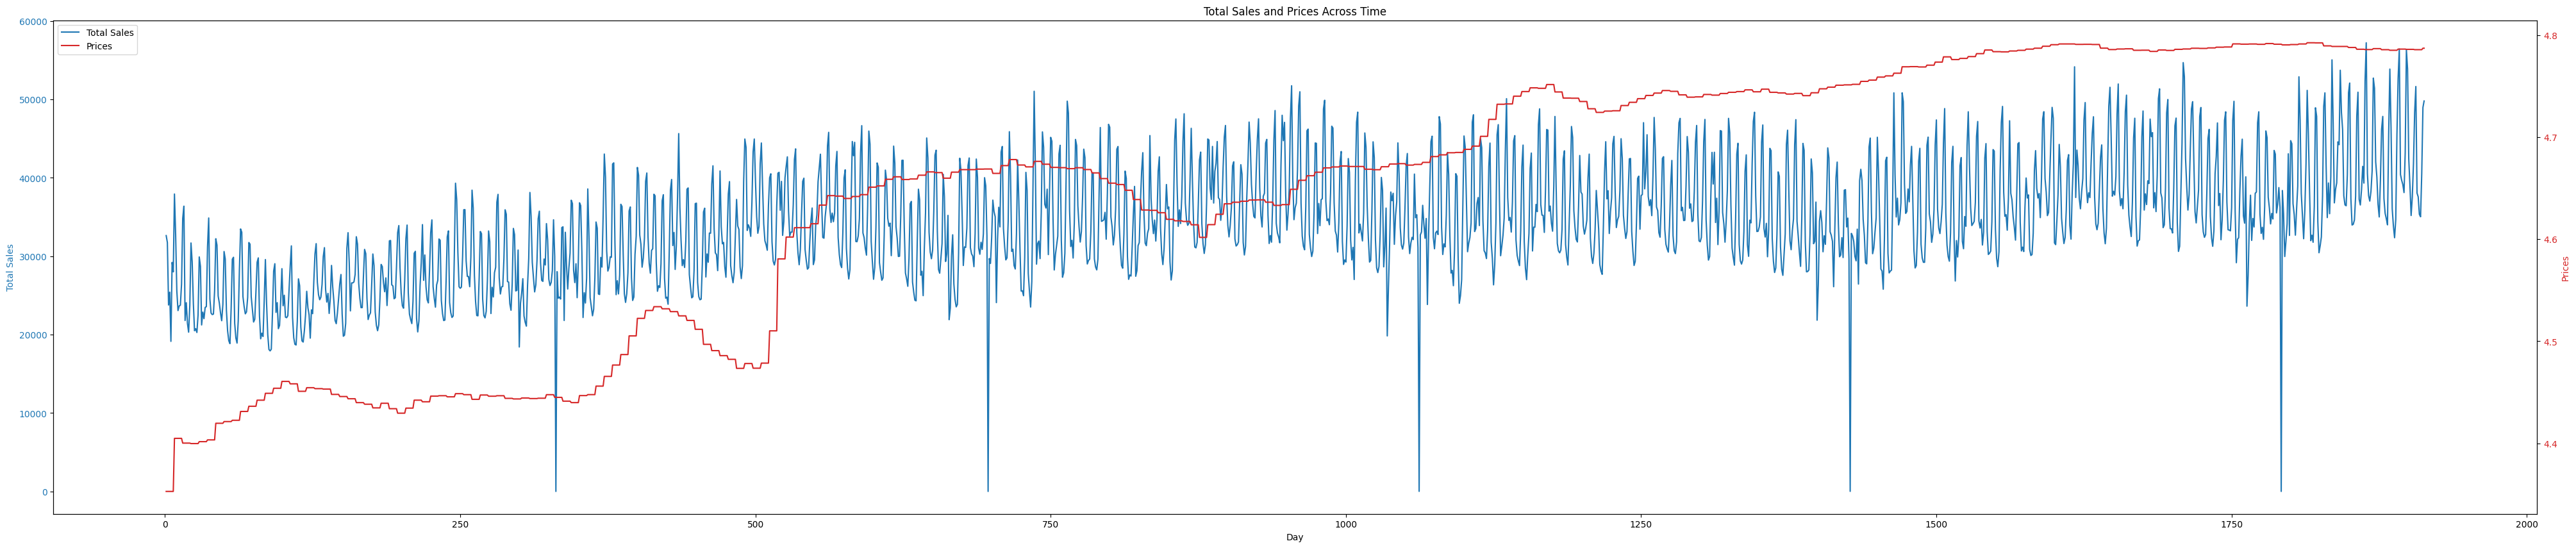

In [ ]:
total_sales_per_day = df.groupby('day')['sales'].sum().reset_index()
average_price_per_day = df.groupby('day')['sell_price'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(50, 10))

color = 'tab:blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Sales', color=color)
ax1.plot(total_sales_per_day['day'], total_sales_per_day['sales'], color=color, label='Total Sales')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Prices', color=color)
ax2.plot(average_price_per_day['day'], average_price_per_day['sell_price'], color=color, label='Prices')
ax2.tick_params(axis='y', labelcolor=color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Total Sales and Prices Across Time')
plt.show()

Since we are interested in our data as a time series, we plotted average sales and prices across time. We saw some interesting patterns and outliers so we conducted more analysis to investigate.

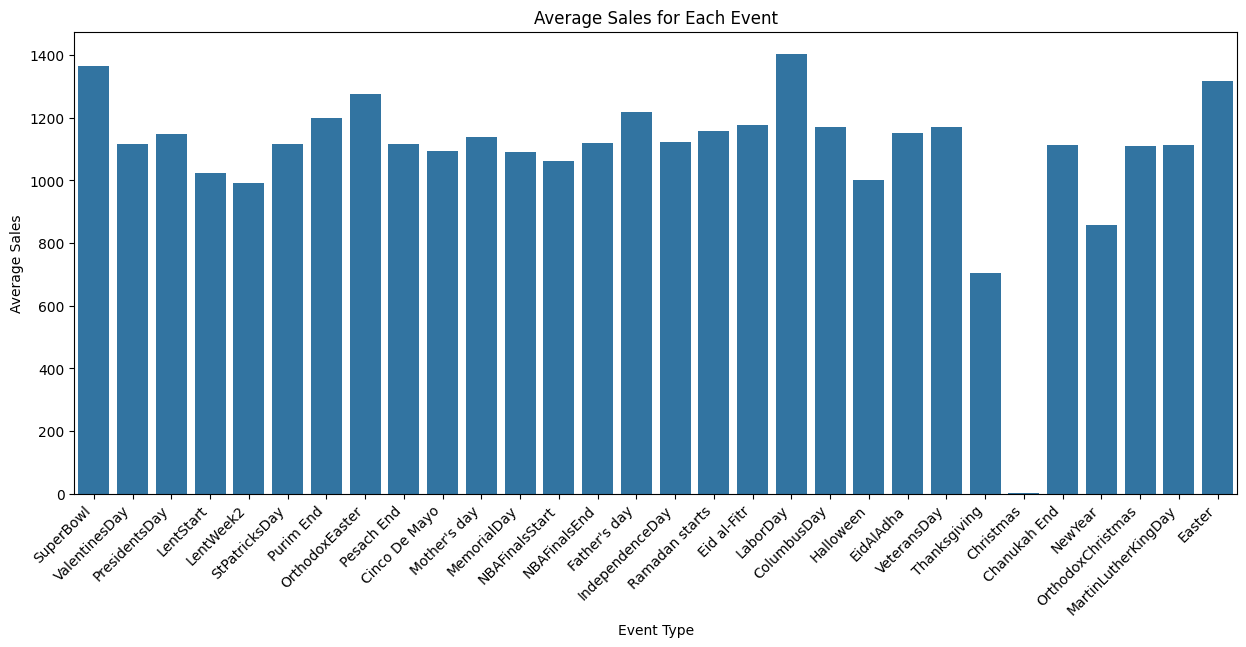

In [ ]:
temp = df
temp['event_type_1'].fillna('No Event', inplace=True)

plt.figure(figsize=(15, 6))
sns.barplot(x='event_name_1', y='sales', data=temp, errorbar=None)
plt.xlabel('Event Type')
plt.ylabel('Average Sales')
plt.title('Average Sales for Each Event')
plt.xticks(rotation=45, ha='right')
plt.show()

We noticed there were some outliers for total sales on some days. Our hypothesis was that the type of event affected the average sales on certain days. Some events were holidays, so there were no sales. We plotted the average sales by event type on a bar graph and noticed there were close to no sales on Christmas, and significantly reduced average sales on Thanksgiving. This explained the outliers we noticed for the days with noticeably lower average sales. We also noticed the Labor Day and the SuperBowl were events with significantly higher sales. This explained the outliers that had significantly higher average sales.

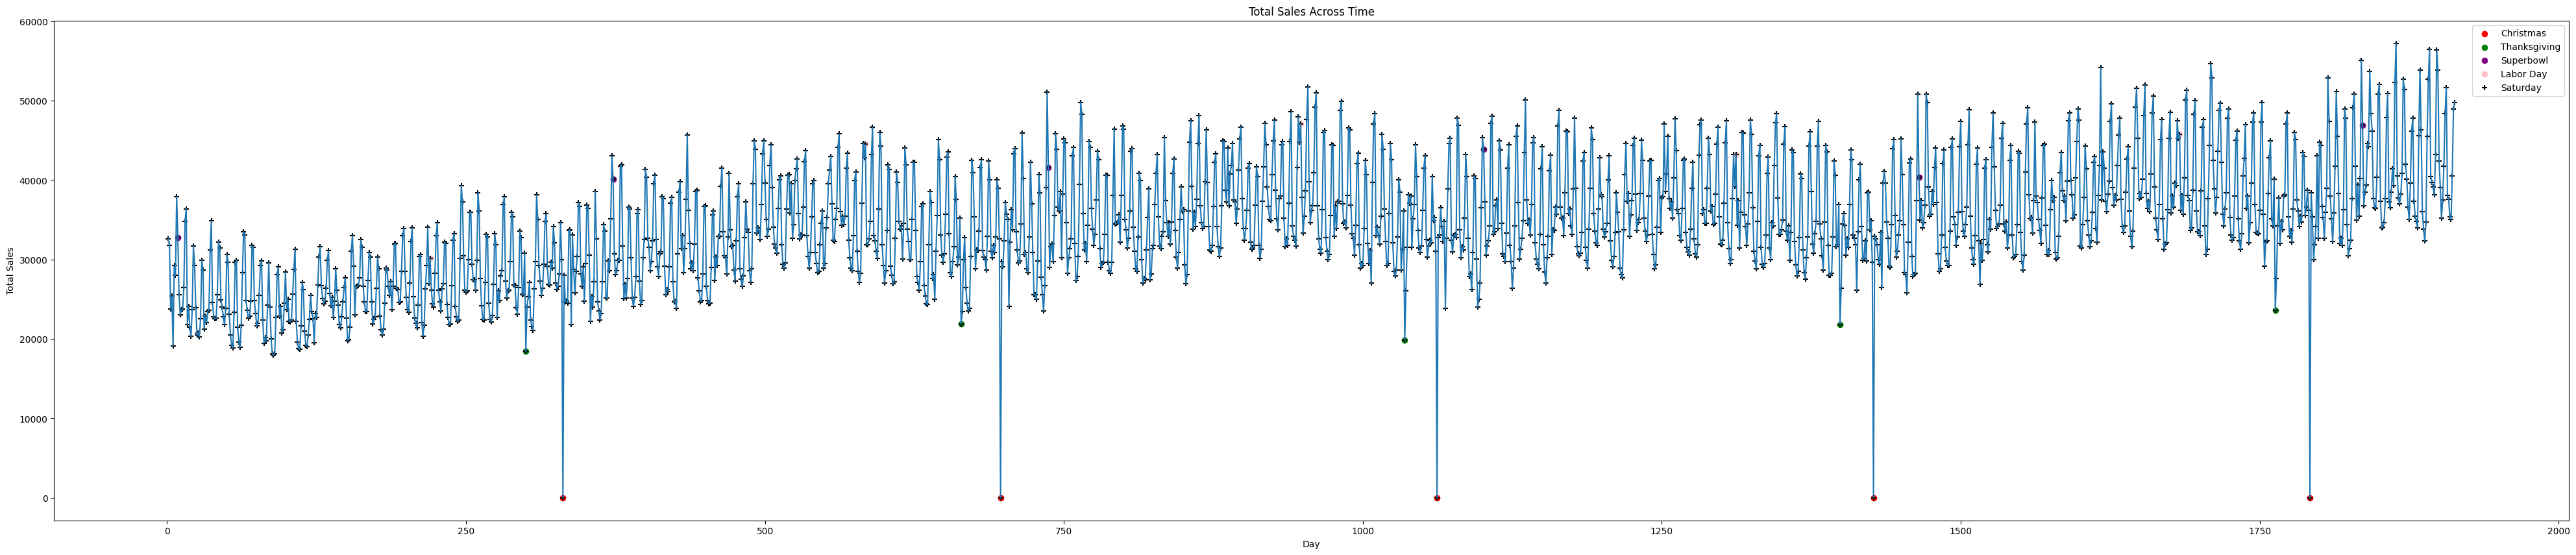

In [ ]:
temp = df.groupby('day').agg({'sales': 'sum', 'event_name_1': 'max'}).reset_index()
temp2 = df.groupby('day').agg({'sales': 'sum', 'wday': 'max'}).reset_index()

plt.figure(figsize=(50, 10))
plt.plot(total_sales_per_day['day'], total_sales_per_day['sales'])
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.title('Total Sales Across Time')

#non_nan_points = df.dropna(subset=['event_type_1'])

christmas = temp[temp['event_name_1'] == 'Christmas']
plt.scatter(christmas['day'], christmas['sales'], color='red', label='Christmas')

thanksgiving = temp[temp['event_name_1'] == 'Thanksgiving']
plt.scatter(thanksgiving['day'], thanksgiving['sales'], color='green', label='Thanksgiving')

superbowl = temp[temp['event_name_1'] == 'SuperBowl']
plt.scatter(superbowl['day'], superbowl['sales'], color='purple', label='Superbowl')

laborday = temp[temp['event_name_1'] == 'LaborDay']
plt.scatter(laborday['day'], laborday['sales'], color='pink', label='Labor Day')

weeks = temp2[temp2['wday'] == 1]
plt.scatter(temp2['day'], temp2['sales'], color='black', label='Saturday', marker='+')

plt.legend()
plt.show()

To check if we were correct, we marked Christmas, Thanksgiving, the Superbowl, and Labor Day on our time series. As seen in the graph, they did in fact expain the outliers. We also marked the beginning of every week on our time series which helped to explain some of the local outliers and overall variation in sales.

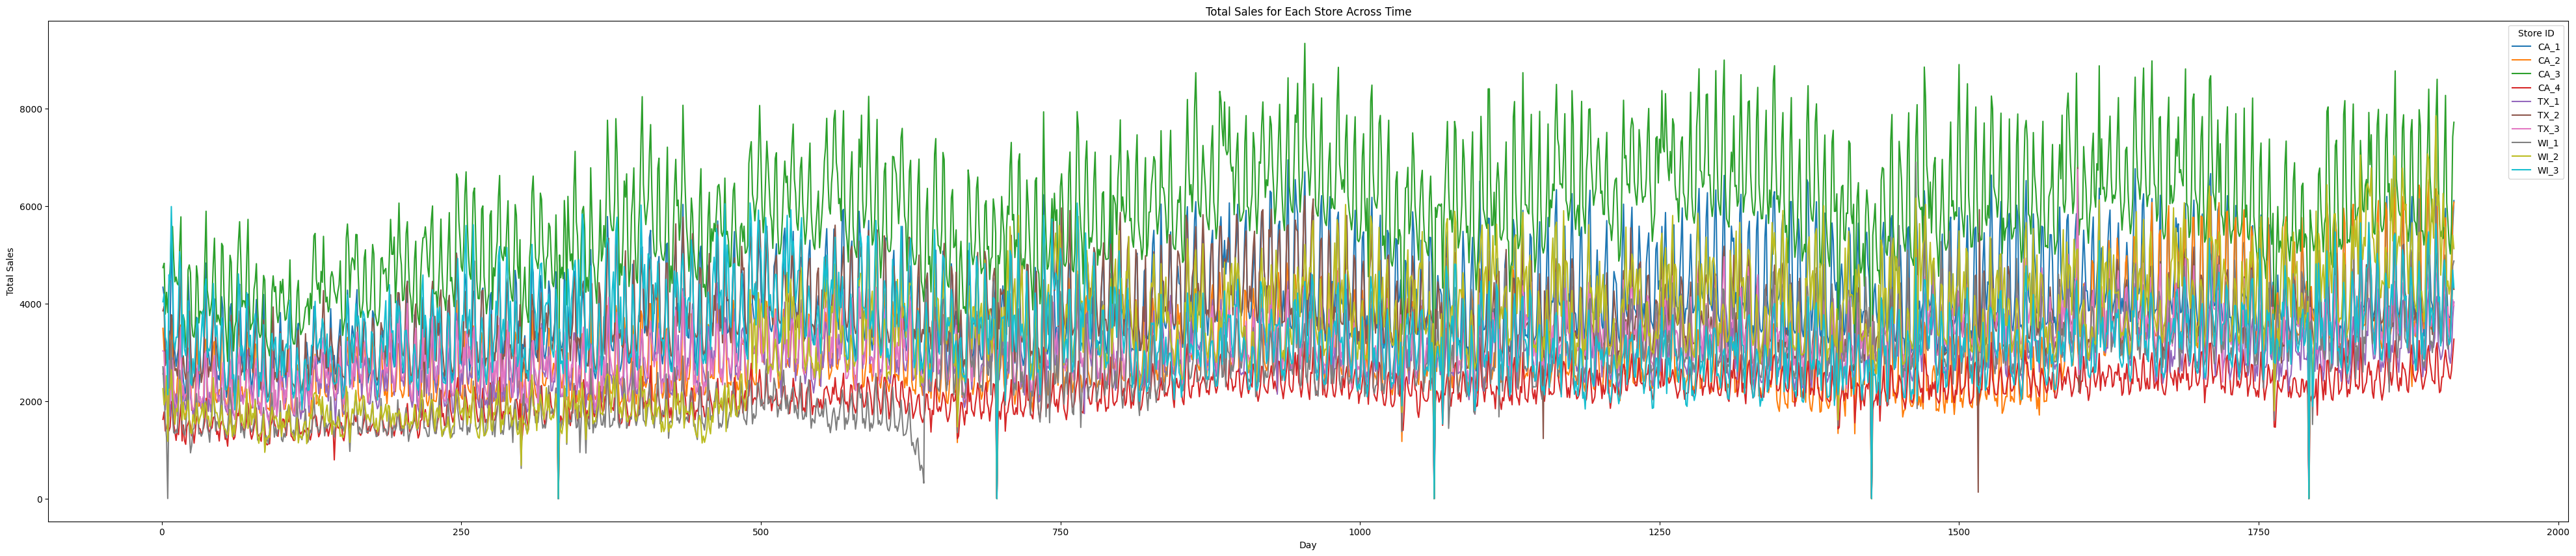

In [ ]:
sum_sales_by_store_day = df.groupby(['store_id', 'day'])['sales'].sum().reset_index()

fig, ax = plt.subplots(figsize=(50,10))

for store_id, group_data in sum_sales_by_store_day.groupby('store_id'):
    ax.plot(group_data['day'], group_data['sales'], label=store_id)

ax.set_xlabel('Day')
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales for Each Store Across Time')
ax.legend(title='Store ID')

plt.show()

The above graph shows the total sales for each store. As depicted by the green data line above the rest of the colors, the CA_3 store experienced the highest number of sales compared to the rest of the stores included in the data set. CA_4, which is represented by the red line, seems to have the lowest sales volume compared to the other stores for the majority of days.

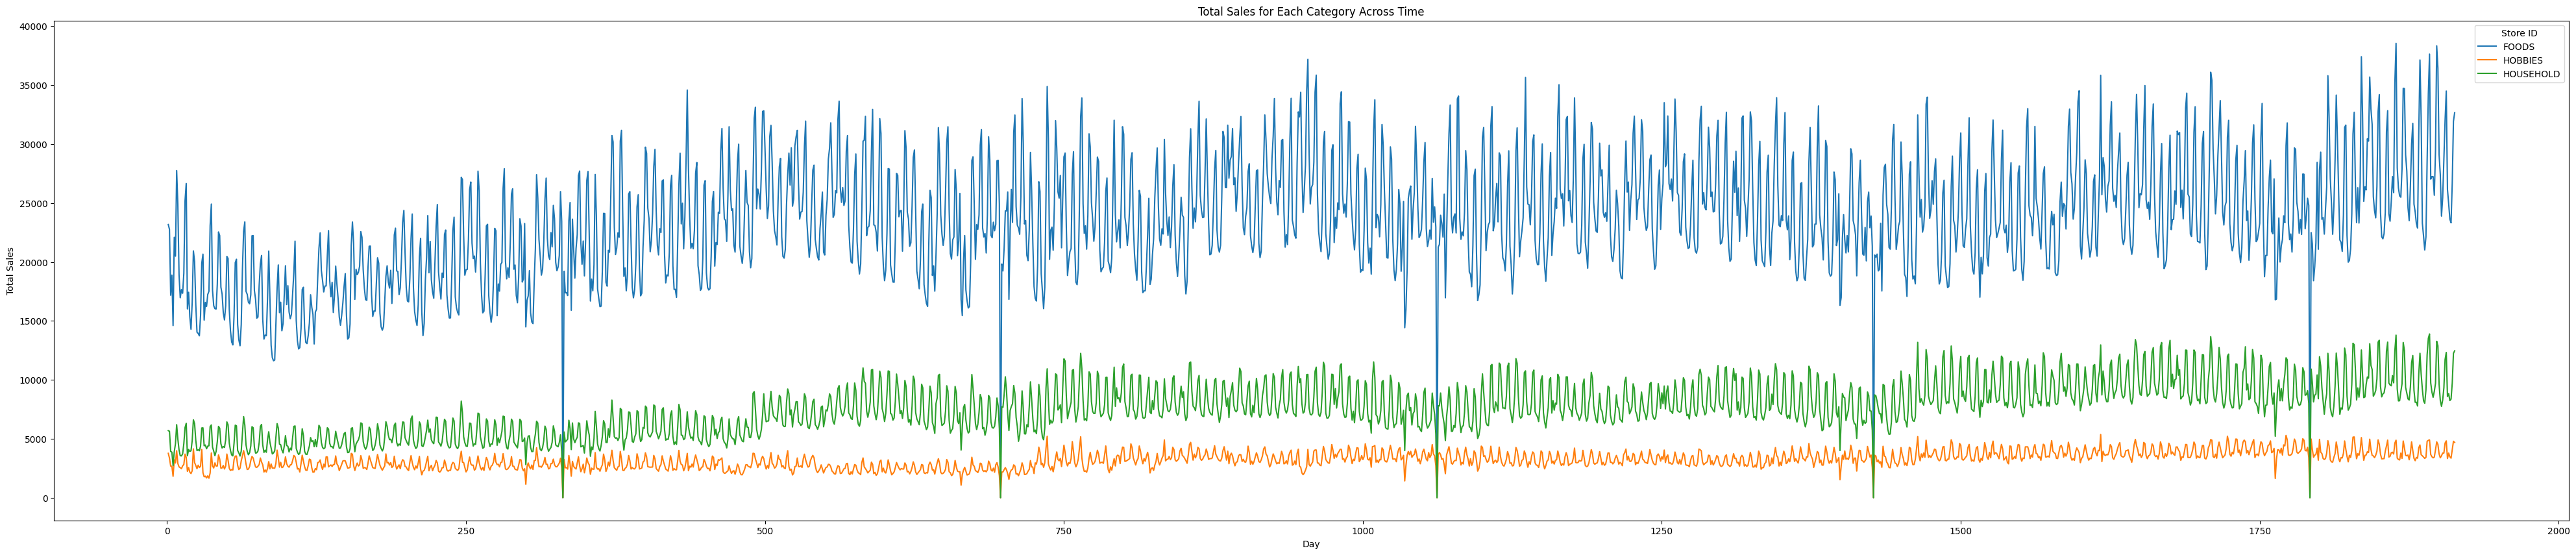

In [ ]:
sum_sales_by_category = df.groupby(['cat_id', 'day'])['sales'].sum().reset_index()

fig, ax = plt.subplots(figsize=(50,10))

for cat_id, group_data in sum_sales_by_category.groupby('cat_id'):
    ax.plot(group_data['day'], group_data['sales'], label=cat_id)

ax.set_xlabel('Day')
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales for Each Category Across Time')
ax.legend(title='Store ID')

plt.show()

We broke the time series graph down first by category and then by store to
see if there were any trends or patterns. This graph shows the total sales by category accross time, with the blue corresponding to 'Foods', green for 'Household', and orange for 'Hobbies'. The main takeaway from this is that there was highest total sales as well as variation for items in the 'Foods' category (blue).

/var/folders/0r/w7dqqrdj26s2z8glpf1rq2b00000gp/T/ipykernel_96699/553406896.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


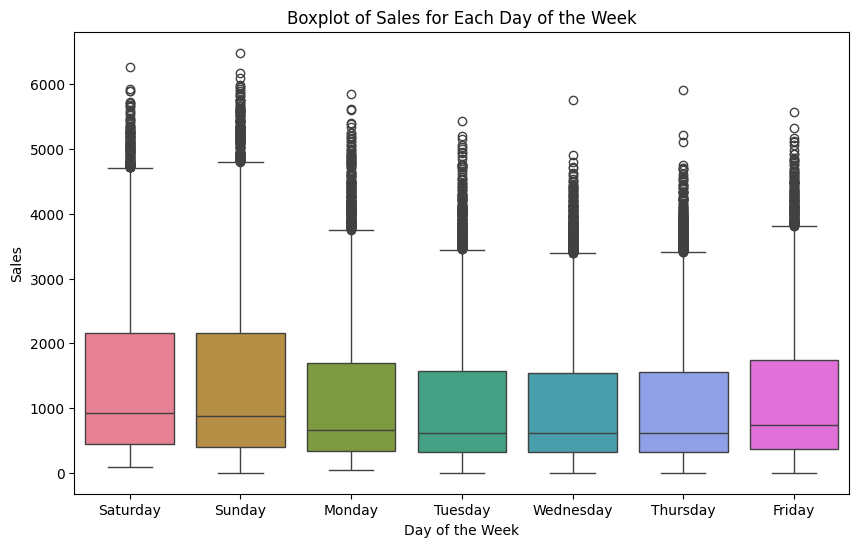

In [ ]:
days_of_week_df = df.groupby('wday')['sales'].sum().reset_index()

day_palette = sns.color_palette("husl", n_colors=len(df['wday'].unique()))

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='wday', y='sales', hue='wday', data=df, palette=day_palette)
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.title('Boxplot of Sales for Each Day of the Week')

new_labels = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
ax.set_xticklabels(new_labels)
ax.get_legend().remove()

plt.show()

Boxplot of Sales for Each Day of the Week: Starting on Saturday, the plot shows the outliers at the top  with the median around 900 sales each day for the week. It can be observed that the weekends provide higher opprotunities for shoppers with higher medians and max sales.

/var/folders/0r/w7dqqrdj26s2z8glpf1rq2b00000gp/T/ipykernel_96699/2294768967.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


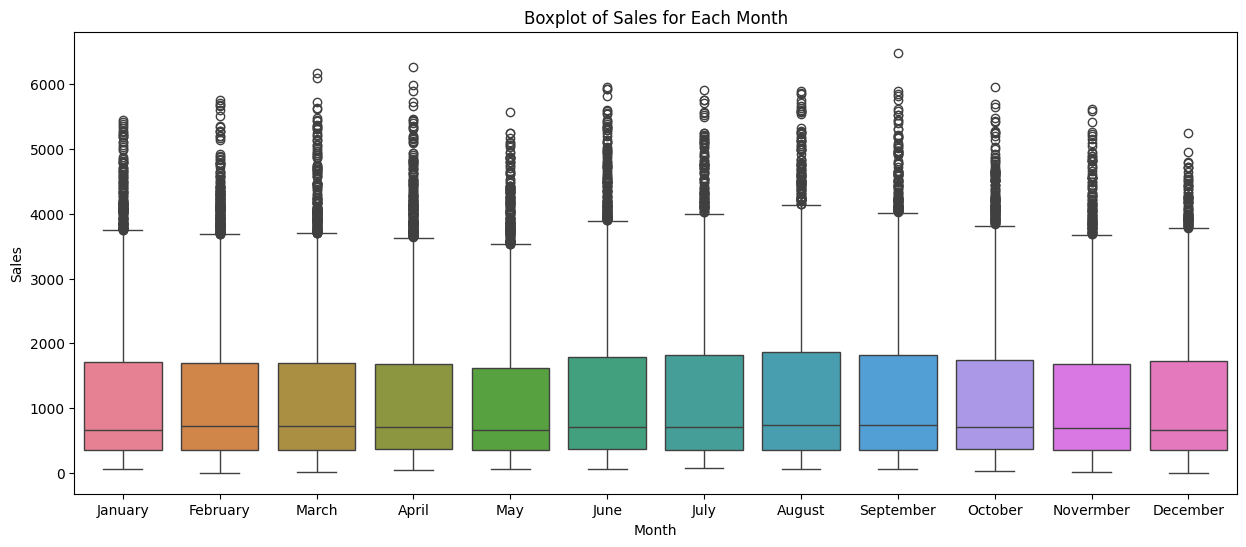

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

month_palette = sns.color_palette("husl", n_colors=len(df['month'].unique()))

plt.figure(figsize=(15, 6))
ax = sns.boxplot(x='month', y='sales', hue='month', data=df, palette=month_palette)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Boxplot of Sales for Each Month')

new_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'Novermber', 'December']
ax.set_xticklabels(new_labels)
ax.get_legend().remove()

plt.show()

Boxplot of Sales for Each Month: Same scenario with boxplot of sales for each month, we have extreme outliers and a consistent median. It should also be noted that the summer months provide higher max and median sales compared to any other months.

# (Part 3) The following code is for constructing our baseline OLS model

In [ ]:
# test data
test_df = pd.read_csv('test.csv')
test_df['date'] = pd.to_datetime(test_df['date'])


# train data
train_df = pd.read_csv('output.csv')
train_df['date'] = pd.to_datetime(train_df['date'])


### Model One (Baseline Linear Regression)

In [ ]:
# read in and format training data
model_one_train = train_df
model_one_train['event_type_1'].fillna('None', inplace=True)
model_one_train['month_name'] = model_one_train['date'].dt.strftime('%B')

#train model
model_one = smf.ols(formula='sales ~ cat_id + store_id + state_id + weekday + month_name + year + event_type_1 + snap_CA + snap_TX + snap_WI + sell_price', data=model_one_train).fit()
model_one.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     7551.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:07:51   Log-Likelihood:            -4.2986e+05
No. Observations:               57390   AIC:                         8.598e+05
Df Residuals:                   57352   BIC:                         8.601e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.834e+05   2875.260    -63.799      0.000   -1.89e+05   -1.78e+05
cat_id[T.HOBBIES]         -1940.8265     20.122    -96.455      0.000   -1980.265   -1901.388
cat_id[T.HOUSEHOLD]       -1492.9910     22.328    -66.865      0.000   -1536.755   -1449.227
store_id[T.CA_2]           -353.4226      8.109    -43.584      0.000    -369.316    -337.529
store_id[T.CA_3]            607.8898      8.090     75.138      0.000     592.033     623.747
store_id[T.CA_4]           -624.7563      8.097    -77.163      0.000    -640.626    -608.887
store_id[T.TX_1]           -184.0507      4.955    -37.146      0.000    -193.762    -174.339
store_id[T.TX_2]             97.5053      4.958     19.666      0.000      87.788     107.223
store_id[T.TX_3]            -97.4161      4.954    -19.663      0.000    -107.127     -87.706
store_id[T.WI_1]           -228.1811      4.956    -46.041      0.000    -237.895    -218.467
store_id[T.WI_2]             16.0577      4.955      3.241      0.001       6.345      25.770
store_id[T.WI_3]             -4.5535      4.954     -0.919      0.358     -14.264       5.157
state_id[T.TX]             -183.9615      4.960    -37.088      0.000    -193.683    -174.240
state_id[T.WI]             -216.6769      4.954    -43.736      0.000    -226.387    -206.967
weekday[T.Monday]           -34.0363      6.852     -4.968      0.000     -47.466     -20.607
weekday[T.Saturday]         244.0877      6.769     36.057      0.000     230.820     257.356
weekday[T.Sunday]           236.2128      6.841     34.530      0.000     222.805     249.621
weekday[T.Thursday]        -129.7715      6.792    -19.106      0.000    -143.084    -116.459
weekday[T.Tuesday]         -128.5180      6.780    -18.955      0.000    -141.807    -115.229
weekday[T.Wednesday]       -140.6863      6.797    -20.698      0.000    -154.009    -127.364
month_name[T.August]         94.8364      8.765     10.819      0.000      77.656     112.017
month_name[T.December]        3.7431      8.779      0.426      0.670     -13.464      20.951
month_name[T.February]       11.5869      8.582      1.350      0.177      -5.233      28.407
month_name[T.January]       -53.8817      8.759     -6.152      0.000     -71.050     -36.714
month_name[T.July]           76.2523      8.771      8.693      0.000      59.060      93.444
month_name[T.June]           65.3665      8.923      7.325      0.000      47.877      82.856
month_name[T.March]           0.5402      8.354      0.065      0.948     -15.834      16.914
month_name[T.May]            -9.1572      8.792     -1.042      0.298     -26.390       8.076
month_name[T.November]       11.7568      8.889      1.323      0.186      -5.666      29.179
month_name[T.October]        66.5308      8.781      7.577      0.000      

In [ ]:
# read in and format test data
model_one_test = test_df
model_one_test['event_type_1'].fillna('None', inplace=True)
model_one_test['month_name'] = model_one_test['date'].dt.strftime('%B')

# predict sales using model
model_one_test['predicted_sales'] = model_one.predict(model_one_test)

#calculate RMSE
model_one_test['residuals'] = model_one_test['sales'] - model_one_test['predicted_sales']
model_one_test['squared_residuals'] = model_one_test['residuals'] ** 2
model_one_test_rmse = np.sqrt(model_one_test['squared_residuals'].mean())

print(f"RMSE for test dataset for model one: {model_one_test_rmse}")
print(f"Mean sales for test dataset: {model_one_test['sales'].mean()}")


RMSE for test dataset for model one: 496.5292501986701
Mean sales for test dataset: 1466.3857142857144


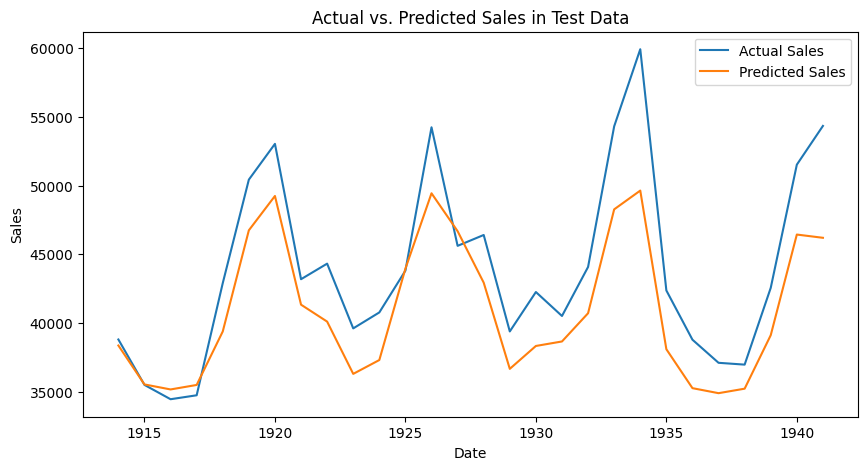

In [ ]:
total_sales_per_day = model_one_test.groupby('day')['sales'].sum().reset_index()
total_predicted_sales_per_day = model_one_test.groupby('day')['predicted_sales'].sum().reset_index()

plt.figure(figsize=(10, 5))

sns.lineplot(x=total_sales_per_day['day'], y=total_sales_per_day['sales'], label='Actual Sales', errorbar=('ci', False))
sns.lineplot(x=total_predicted_sales_per_day['day'], y=total_predicted_sales_per_day['predicted_sales'], label='Predicted Sales', errorbar=('ci', False))

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales in Test Data')

plt.show()

### Model Two (Linear Regression with Interaction Terms)

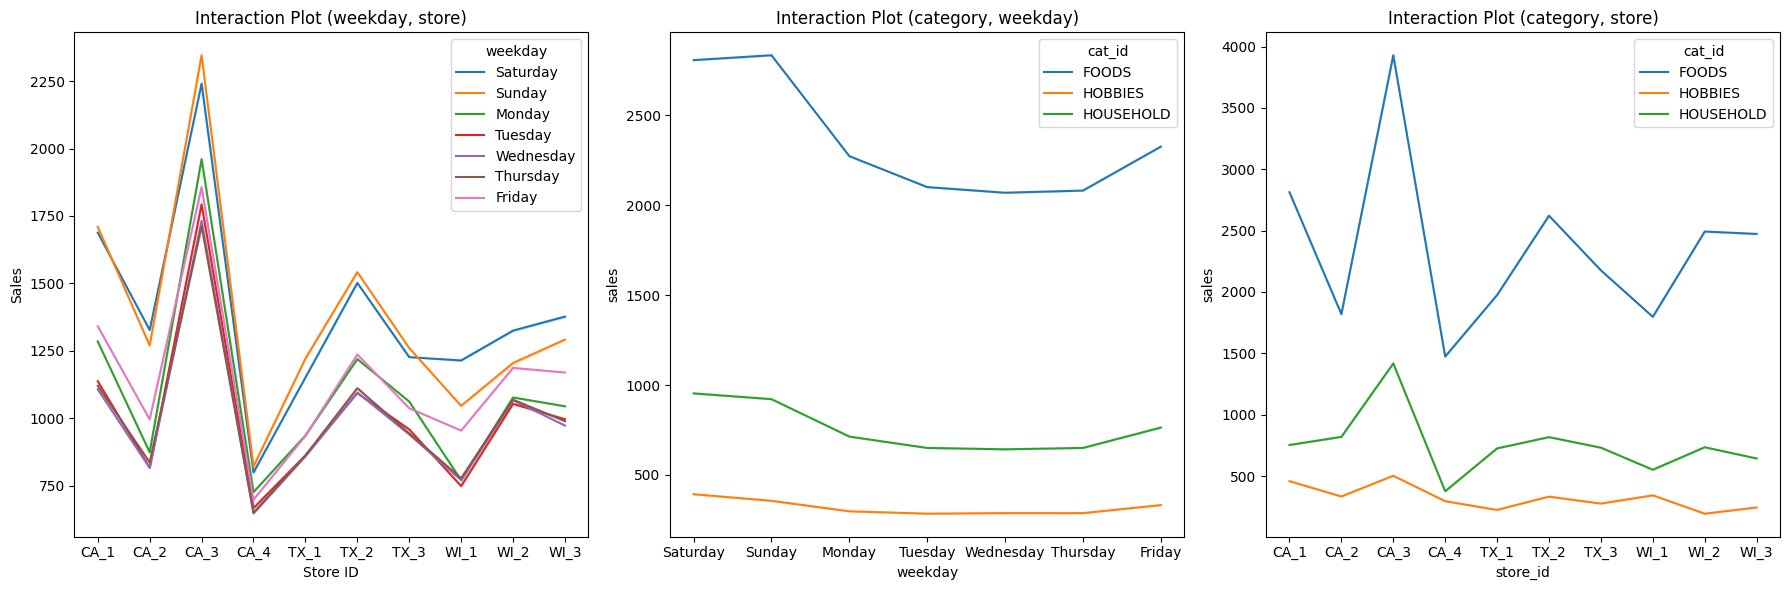

In [ ]:
# Interaction terms
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
sns.lineplot(x='store_id', y='sales', hue="weekday", data=train_df, errorbar=('ci', False), ax=axs[0])
axs[0].set_title('Interaction Plot (weekday, store)')
axs[0].set_xlabel('Store ID')
axs[0].set_ylabel('Sales')


# Plot 2
sns.lineplot(x='weekday', y='sales', hue="cat_id", data=train_df, errorbar=('ci', False), ax=axs[1])
axs[1].set_title('Interaction Plot (category, weekday)')
axs[1].set_xlabel('weekday')
axs[1].set_ylabel('sales')

# Plot 3
sns.lineplot(x='store_id', y='sales', hue="cat_id", data=train_df, errorbar=('ci', False), ax=axs[2])
axs[2].set_title('Interaction Plot (category, store)')
axs[2].set_xlabel('store_id')
axs[2].set_ylabel('sales')

plt.tight_layout()
plt.show()


After looking at these plots, it can be concluded that there is minimal interaction between weekday and store, and moderate interaction between category and weekday, and category and store, in the way that they affect sales.

In [ ]:
# read in and format training data
model_two_train = train_df
model_two_train['event_type_1'].fillna('None', inplace=True)
model_two_train['month_name'] = model_two_train['date'].dt.strftime('%B')

#train model
model_two = smf.ols(formula='sales ~ cat_id + store_id + state_id + weekday + month_name + year + event_type_1 + snap_CA + snap_TX + snap_WI + sell_price + cat_id*weekday + cat_id*store_id', data=model_two_train).fit()
model_two.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     8077.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:07:54   Log-Likelihood:            -4.1335e+05
No. Observations:               57390   AIC:                         8.268e+05
Df Residuals:                   57322   BIC:                         8.274e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -1.986e+05   2165.666    -91.685      0.000   -2.03e+05   -1.94e+05
cat_id[T.HOBBIES]                        -2030.9019     19.596   -103.637      0.000   -2069.311   -1992.493
cat_id[T.HOUSEHOLD]                      -1703.9599     21.048    -80.957      0.000   -1745.214   -1662.706
store_id[T.CA_2]                         -1022.4600     10.615    -96.320      0.000   -1043.266   -1001.654
store_id[T.CA_3]                          1109.9970     10.516    105.558      0.000    1089.386    1130.607
store_id[T.CA_4]                         -1339.5480     10.511   -127.442      0.000   -1360.150   -1318.946
store_id[T.TX_1]                          -423.4340      6.437    -65.776      0.000    -436.052    -410.816
store_id[T.TX_2]                           223.6990      6.437     34.752      0.000     211.082     236.316
store_id[T.TX_3]                          -222.8675      6.438    -34.617      0.000    -235.486    -210.249
store_id[T.WI_1]                          -603.9762      6.448    -93.670      0.000    -616.614    -591.338
store_id[T.WI_2]                            96.0496      6.438     14.919      0.000      83.431     108.668
store_id[T.WI_3]                            85.1757      6.444     13.217      0.000      72.545      97.807
state_id[T.TX]                            -422.6025      6.445    -65.575      0.000    -435.234    -409.971
state_id[T.WI]                            -422.7509      6.440    -65.648      0.000    -435.373    -410.129
weekday[T.Monday]                          -41.0402      8.833     -4.646      0.000     -58.353     -23.727
weekday[T.Saturday]                        481.4562      8.792     54.760      0.000     464.224     498.689
weekday[T.Sunday]                          514.4214      8.823     58.303      0.000     497.128     531.715
weekday[T.Thursday]                       -240.1387      8.807    -27.266      0.000    -257.401    -222.876
weekday[T.Tuesday]                        -224.8995      8.802    -25.550      0.000    -242.152    -207.647
weekday[T.Wednesday]                      -256.5242      8.810    -29.119      0.000    -273.791    -239.257
month_name[T.August]                        97.8281      6.575     14.878      0.000      84.941     110.715
month_name[T.December]                       8.5241      6.586      1.294      0.196      -4.384      21.432
month_name[T.February]                       9.3472      6.437      1.452      0.146      -3.270      21.964
month_name[T.January]                      -56.6079      6.570     -8.616      0.000     -69.486     -43.730
month_name[T.July]                          78.6765      6.580     11.958      0.000      65.780      91.573
month_name[T.June]             

In [ ]:
# read in and format test data
model_two_test = test_df
model_two_test['event_type_1'].fillna('None', inplace=True)
model_two_test['month_name'] = model_two_test['date'].dt.strftime('%B')

# predict sales using model
model_two_test['predicted_sales'] = model_two.predict(model_two_test)

#calculate RMSE
model_two_test['residuals'] = model_two_test['sales'] - model_two_test['predicted_sales']
model_two_test['squared_residuals'] = model_two_test['residuals'] ** 2
model_two_test_rmse = np.sqrt(model_two_test['squared_residuals'].mean())

print(f"RMSE for test dataset for model two: {model_two_test_rmse}")
print(f"Mean sales for test dataset: {model_two_test['sales'].mean()}")

RMSE for test dataset for model two: 447.4252364724567
Mean sales for test dataset: 1466.3857142857144


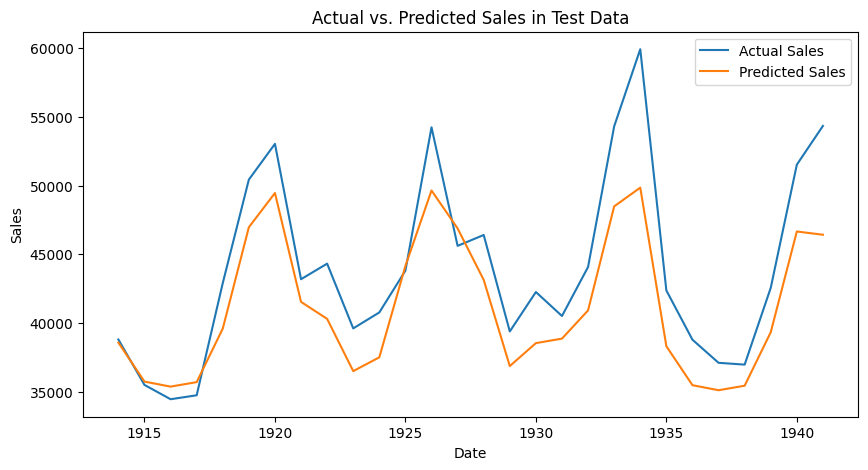

In [ ]:
total_sales_per_day = model_two_test.groupby('day')['sales'].sum().reset_index()
total_predicted_sales_per_day = model_two_test.groupby('day')['predicted_sales'].sum().reset_index()

plt.figure(figsize=(10, 5))

sns.lineplot(x=total_sales_per_day['day'], y=total_sales_per_day['sales'], label='Actual Sales', errorbar=('ci', False))
sns.lineplot(x=total_predicted_sales_per_day['day'], y=total_predicted_sales_per_day['predicted_sales'], label='Predicted Sales', errorbar=('ci', False))

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales in Test Data')

plt.show()

### Model Three (LinReg with event_name)

In [ ]:
# read in and format training data
model_three_train = train_df
model_three_train['event_name_1'].fillna('None', inplace=True)
model_three_train['month_name'] = model_three_train['date'].dt.strftime('%B')

#train model
model_three = smf.ols(formula='sales ~ cat_id + store_id + state_id + weekday + month_name + year + event_name_1 + snap_CA + snap_TX + snap_WI + sell_price + cat_id*weekday + cat_id*store_id', data=model_three_train).fit()
model_three.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     6014.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:07:56   Log-Likelihood:            -4.1248e+05
No. Observations:               57390   AIC:                         8.251e+05
Df Residuals:                   57296   BIC:                         8.260e+05
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -1.983e+05   2134.417    -92.914      0.000   -2.02e+05   -1.94e+05
cat_id[T.HOBBIES]                        -2031.1413     19.307   -105.201      0.000   -2068.984   -1993.299
cat_id[T.HOUSEHOLD]                      -1704.2313     20.737    -82.182      0.000   -1744.877   -1663.586
store_id[T.CA_2]                         -1022.4353     10.459    -97.760      0.000   -1042.934   -1001.936
store_id[T.CA_3]                          1110.0021     10.360    107.140      0.000    1089.696    1130.308
store_id[T.CA_4]                         -1339.5475     10.356   -129.351      0.000   -1359.845   -1319.250
store_id[T.TX_1]                          -423.4322      6.342    -66.761      0.000    -435.864    -411.001
store_id[T.TX_2]                           223.7003      6.342     35.272      0.000     211.270     236.131
store_id[T.TX_3]                          -222.8652      6.343    -35.135      0.000    -235.298    -210.433
store_id[T.WI_1]                          -603.9699      6.353    -95.072      0.000    -616.421    -591.518
store_id[T.WI_2]                            96.0518      6.343     15.143      0.000      83.620     108.484
store_id[T.WI_3]                            85.1705      6.349     13.414      0.000      72.726      97.615
state_id[T.TX]                            -422.5972      6.349    -66.557      0.000    -435.042    -410.152
state_id[T.WI]                            -422.7476      6.345    -66.631      0.000    -435.183    -410.312
weekday[T.Monday]                          -66.6449      8.751     -7.616      0.000     -83.797     -49.493
weekday[T.Saturday]                        477.4365      8.668     55.082      0.000     460.448     494.425
weekday[T.Sunday]                          519.5257      8.743     59.421      0.000     502.389     536.662
weekday[T.Thursday]                       -239.1348      8.700    -27.488      0.000    -256.186    -222.084
weekday[T.Tuesday]                        -225.3530      8.680    -25.961      0.000    -242.367    -208.339
weekday[T.Wednesday]                      -256.9495      8.708    -29.507      0.000    -274.018    -239.882
month_name[T.August]                        95.5185      6.580     14.516      0.000      82.622     108.415
month_name[T.December]                      35.5787      6.679      5.327      0.000      22.487      48.670
month_name[T.February]                       0.8374      6.645      0.126      0.900     -12.186      13.861
month_name[T.January]                      -58.0675      6.712     -8.651      0.000     -71.224     -44.911
month_name[T.July]                          73.7463      6.634     11.117      0.000      60.745      86.748
month_name[T.June]             

In [ ]:
# read in and format test data
model_three_test = test_df
model_three_test['event_type_1'].fillna('None', inplace=True)
model_three_test['month_name'] = model_three_test['date'].dt.strftime('%B')

# predict sales using model
model_three_test['predicted_sales'] = model_three.predict(model_three_test)

#calculate RMSE
model_three_test['residuals'] = model_three_test['sales'] - model_three_test['predicted_sales']
model_three_test_rmse = np.sqrt(model_three_test['squared_residuals'].mean())

print(f"RMSE for test dataset for model three: {model_three_test_rmse}")
print(f"Mean sales for test dataset: {model_three_test['sales'].mean()}")

RMSE for test dataset for model three: 447.4252364724567
Mean sales for test dataset: 1466.3857142857144


There was no improvement in the RMSE so we will not use event_name_1.

### Model Four (LinReg with Lags)

In [ ]:
# read in and format training data
model_four_train = train_df
model_four_train['event_type_1'].fillna('None', inplace=True)
model_four_train['month_name'] = model_one_train['date'].dt.strftime('%B')

#train model
model_four = smf.ols(formula='sales ~ cat_id + store_id + state_id + weekday + month_name + year + event_type_1 + snap_CA + snap_TX + snap_WI + sell_price', data=model_four_train).fit()
model_four.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     7551.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:07:57   Log-Likelihood:            -4.2986e+05
No. Observations:               57390   AIC:                         8.598e+05
Df Residuals:                   57352   BIC:                         8.601e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.834e+05   2875.260    -63.799      0.000   -1.89e+05   -1.78e+05
cat_id[T.HOBBIES]         -1940.8265     20.122    -96.455      0.000   -1980.265   -1901.388
cat_id[T.HOUSEHOLD]       -1492.9910     22.328    -66.865      0.000   -1536.755   -1449.227
store_id[T.CA_2]           -353.4226      8.109    -43.584      0.000    -369.316    -337.529
store_id[T.CA_3]            607.8898      8.090     75.138      0.000     592.033     623.747
store_id[T.CA_4]           -624.7563      8.097    -77.163      0.000    -640.626    -608.887
store_id[T.TX_1]           -184.0507      4.955    -37.146      0.000    -193.762    -174.339
store_id[T.TX_2]             97.5053      4.958     19.666      0.000      87.788     107.223
store_id[T.TX_3]            -97.4161      4.954    -19.663      0.000    -107.127     -87.706
store_id[T.WI_1]           -228.1811      4.956    -46.041      0.000    -237.895    -218.467
store_id[T.WI_2]             16.0577      4.955      3.241      0.001       6.345      25.770
store_id[T.WI_3]             -4.5535      4.954     -0.919      0.358     -14.264       5.157
state_id[T.TX]             -183.9615      4.960    -37.088      0.000    -193.683    -174.240
state_id[T.WI]             -216.6769      4.954    -43.736      0.000    -226.387    -206.967
weekday[T.Monday]           -34.0363      6.852     -4.968      0.000     -47.466     -20.607
weekday[T.Saturday]         244.0877      6.769     36.057      0.000     230.820     257.356
weekday[T.Sunday]           236.2128      6.841     34.530      0.000     222.805     249.621
weekday[T.Thursday]        -129.7715      6.792    -19.106      0.000    -143.084    -116.459
weekday[T.Tuesday]         -128.5180      6.780    -18.955      0.000    -141.807    -115.229
weekday[T.Wednesday]       -140.6863      6.797    -20.698      0.000    -154.009    -127.364
month_name[T.August]         94.8364      8.765     10.819      0.000      77.656     112.017
month_name[T.December]        3.7431      8.779      0.426      0.670     -13.464      20.951
month_name[T.February]       11.5869      8.582      1.350      0.177      -5.233      28.407
month_name[T.January]       -53.8817      8.759     -6.152      0.000     -71.050     -36.714
month_name[T.July]           76.2523      8.771      8.693      0.000      59.060      93.444
month_name[T.June]           65.3665      8.923      7.325      0.000      47.877      82.856
month_name[T.March]           0.5402      8.354      0.065      0.948     -15.834      16.914
month_name[T.May]            -9.1572      8.792     -1.042      0.298     -26.390       8.076
month_name[T.November]       11.7568      8.889      1.323      0.186      -5.666      29.179
month_name[T.October]        66.5308      8.781      7.577      0.000      

### Model Five (boosted decision tree regression)